In [1]:
# Import some basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import the raw dataset
df = pd.read_csv('data_clean.csv')
df.head()

,Unnamed: 0,helpful,text
0,0,1,I have bought several of the Vitality canned d...
1,1,0,Product arrived labeled as Jumbo Salted Peanut...
2,2,1,This is a confection that has been around a fe...
3,3,3,If you are looking for the secret ingredient i...
4,4,0,Great taffy at a great price. There was a wid...


In [6]:
# Get just the texts for modeling
data = df['text']

In [7]:
# Set up stopwords to be removed
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennykreiger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Topic modeling for full dataset

The following code was adapted from a demonstration by Olivier Grisel, Lars Buitinck, and Chyi-Kwei Yau (license: BSD 3 clause) available at [https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html). Their demo produces topics using three different models: NMF with Frobenius norm (default), NMF with generalized Kullback-Leibler divergence, and LDA, all taking a matrix of TF-IDF values as input. 

Playing around with their code, I determined that the first NMF model produced the most reasonable, internally coherent topics based on the top words. NMF stands for "non-negative matrix factorization," and it's basically a way to take the matrix of TF-IDF values representing your corpus and decompose it into two matrices that, when multiplied together (dot product), would return your original matrix. This technique is useful for topic modeling, as we see here, but also for reducing the dimensionality of a dataset. See the [documentation on sklearn.decomposition.NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) to learn more about how this object works.

Let's take a look at what 20 topics would look like for this dataset. Note that I'm modeling the topics based on a smallish sample of 30000 reviews (roughly 10% of the dataset), but using relatively large TF-IDF vectors of length 1000.

In [52]:
# Create a function to model topics using NMF
def nmf_it(data, n_samples, n_features, n_components, n_top_words):
    
    # Import TfidfVectorizer and NMF
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.decomposition import NMF
    
    # Get sample of data
    data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words=stop_list)

    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    
    # Fit the NMF model
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    # View top words for each topic
    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return tfidf, nmf

In [53]:
tfidf, nmf = nmf_it(data, 30000, 1000, 20, 10)


Topics in NMF model (Frobenius norm):
Topic #0: one would time get box first tried try bought bag
Topic #1: tea green teas drink bags black iced cup chai drinking
Topic #2: coffee cup strong cups roast starbucks bold keurig drink bitter
Topic #3: food dog dogs treats cat loves cats eat treat dry
Topic #4: price buy store amazon shipping grocery local better much cheaper
Topic #5: great snack easy tastes tasting loves make value deal fast
Topic #6: chocolate dark milk bar cookies cocoa hot bars cookie chip
Topic #7: taste better drink bad bitter texture sweet smell would tried
Topic #8: product recommend excellent would arrived quality purchase products highly use
Topic #9: good really pretty quality stuff tastes quite little deal bit
Topic #10: sugar snack sweet cereal bars calories low healthy fat bar
Topic #11: love dogs kids stuff absolutely perfect snack cats wish best
Topic #12: sauce hot chicken pasta heat add sauces spicy cheese noodles
Topic #13: flavor nice flavors favorite v

Looking at the top words and comparing them to the selection of reviews I have read, I can good representation of this corpus' major themes of coffee, tea, pet foods, chips, packaging, flavor preferences, and Amazon v. local stores.

But how do I know that 20 is the right or best number of topics to model? Luckily, there are ways to approach this problem. The Yellowbrick package offers a convenient way to run a K-means clustering algorithm on our matrix of TF-IDF values to find the optimal number of clusters to look for in this text data.

Let's take a look at that:

In [54]:
# Import needed objects
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the KMeans model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10, 30))

# Fit the visualizer and plot the results
visualizer.fit(tfidf)       
visualizer.show()        

KeyboardInterrupt: 

The plot above indicates that 20 clusters is in fact a good choice for this dataset. 

This makes me wonder: could topic modeling be another way to approach the problem of distinguishing helpful from unhelpful reviews? If I were to use an NMF model to find just two clusters, would those clusters correspond in any way to helpful/unhelpful?

In [ ]:
nmf_it(data, 30000, 1000, 2, 20)

# Visualizing topic clusters

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

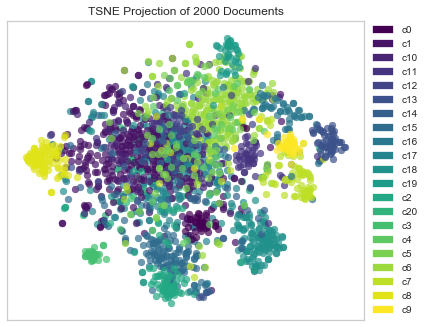

In [55]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer

# Load the data and create document vectors
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(data)
clusters = KMeans(n_clusters=21)
clusters.fit(X)

cmap = plt.cm.get_cmap('viridis', 21)
tsne = TSNEVisualizer(colormap=cmap)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()

In [60]:
cmap = plt.cm.get_cmap('RdBu')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


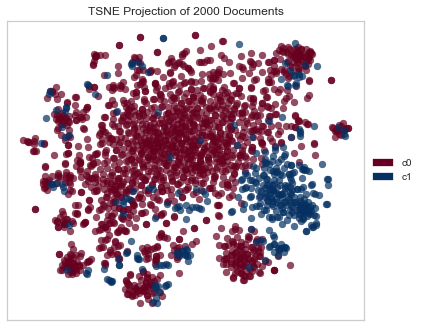

In [61]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(data_brief.Text)
clusters = KMeans(n_clusters=2)
clusters.fit(X)

tsne = TSNEVisualizer(colormap=cmap)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()